In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import matplotlib
import scipy.optimize as opt
from sklearn.metrics import classification_report

In [50]:
data = sio.loadmat('D:\机器学习——Andrew_rag\code\ex4-NN back propagation\ex4data1.mat')
data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sun Oct 16 13:09:09 2011',
 '__version__': '1.0',
 '__globals__': [],
 'X': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'y': array([[10],
        [10],
        [10],
        ...,
        [ 9],
        [ 9],
        [ 9]], dtype=uint8)}

In [51]:
x = data['X']#每一行是一个数字图（20*20），5000个20*20像素的手写字体图像
y = data['y']#对应里面图像的数字
print(x.shape)
print(y.shape)

(5000, 400)
(5000, 1)


In [60]:
def transpose(x):
    #把每一行还原为20×20的(正常图片显示)二维数组形式,共5000行，每一行一个二维数组(这一步其实就是将图片（20*20）转置过来)
    x = np.array([im.reshape((20,20)).T for im in x])
    x = np.array([im.reshape(400) for im in x])
    return x

x = transpose(x)
print(x.shape)

(5000, 400)


size直接换成20\*20还是未转置之前，图像仍为倒转，所以要有第一个size=int()提取出原来的size（20\*20）

In [61]:
def plot_im(x):
    size = int(np.sqrt(x.shape[1]))#sqrt（400）=20，保持size为原始像素20,为后面准备
    sample_indx = np.random.choice(x.shape[0],100)#5000张图片中随机抽100张
    sample_img = x[sample_indx,:]#索引100张图片

    #10行10列，每一张大小为8*8
    fig, ax_array = plt.subplots(nrows=10, ncols=10, sharey=True, sharex=True, figsize=(8,8))

    for r in range(10):
        for c in range(10):
            #matshow()绘制函数矩阵，cmap意思是color map，颜色方案，binary代表是白底黑字
            ax_array[r,c].matshow(sample_img[10 * r + c].reshape((size,size)),
                                  cmap=matplotlib.cm.binary)
            plt.xticks(np.array([]))
            plt.yticks(np.array([]))

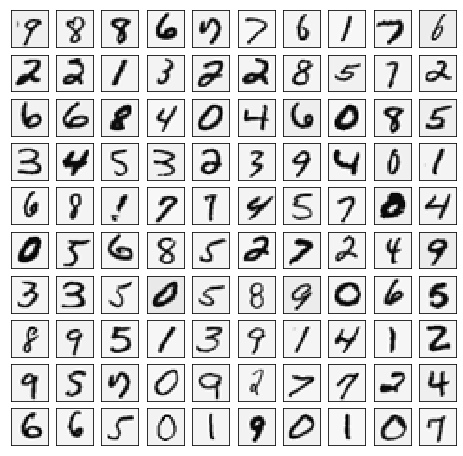

In [62]:
plot_im(x)
plt.show()

读取权重

In [63]:
def load_weights(path):
    data = sio.loadmat(path)
    return data['Theta1'], data['Theta2']

In [64]:
theta1, theta2 = load_weights('D:\机器学习——Andrew_rag\code\ex4-NN back propagation\ex4weights.mat')
print(theta1.shape)
print(theta2.shape)

(25, 401)
(10, 26)


np.ravel()是将原数组拉成一维数组

In [65]:
def serialize(a,b):
    return np.concatenate((np.ravel(a), np.ravel(b)))

In [67]:
theta = serialize(theta1, theta2)
theta.shape

(10285,)

* (a,)是指一维数组，有a个元素
* (a,b)是指二维数组，每个a数组中有b个元素

# 前向传播

In [13]:
data2 = sio.loadmat('D:\机器学习——Andrew_rag\code\ex4-NN back propagation\ex4data1.mat')
x_raw = data2['X']
y_raw = data2['y']
x = np.insert(x_raw, 0, np.ones(x.shape[0]), axis=1)
x.shape

(5000, 401)

In [14]:
from sklearn.preprocessing import OneHotEncoder #导入onehotEncoder
encoder = OneHotEncoder(sparse=False) #非稀疏
y_onehot = encoder.fit_transform(y_raw) #一般接收二维数组
print(y_onehot.shape)
print(y_onehot)

(5000, 10)
[[0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]]


In [15]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

参数向量转换回矩阵  
seq[:25\*401]代表0-25*401的元素即为theta1，这样提取出theta1参数reshape回(25,401)矩阵  
seq[25\*401:]代表第25*401-最后一个元素即为theta2，这样同上提取出theta2参数

In [16]:
def deserialize(seq):
    return seq[:25 *401].reshape(25,401), seq[25 *401:].reshape(10,26)

In [17]:
def feedforward(theta, x):
    t1,t2 = deserialize(theta)
    m = x.shape[0]
    a1 = x

    z2 = a1 @ t1.T
    a2 = np.insert(sigmoid(z2), 0, np.ones(m), axis=1)#加入初始项，例如一开始的x.insert

    z3 = a2 @ t2.T
    h = sigmoid(z3)

    return a1, z2, a2, z3, h

In [18]:
_, _, _, _, h = feedforward(theta, x)
h

array([[1.12661530e-04, 1.74127856e-03, 2.52696959e-03, ...,
        4.01468105e-04, 6.48072305e-03, 9.95734012e-01],
       [4.79026796e-04, 2.41495958e-03, 3.44755685e-03, ...,
        2.39107046e-03, 1.97025086e-03, 9.95696931e-01],
       [8.85702310e-05, 3.24266731e-03, 2.55419797e-02, ...,
        6.22892325e-02, 5.49803551e-03, 9.28008397e-01],
       ...,
       [5.17641791e-02, 3.81715020e-03, 2.96297510e-02, ...,
        2.15667361e-03, 6.49826950e-01, 2.42384687e-05],
       [8.30631310e-04, 6.22003774e-04, 3.14518512e-04, ...,
        1.19366192e-02, 9.71410499e-01, 2.06173648e-04],
       [4.81465717e-05, 4.58821829e-04, 2.15146201e-05, ...,
        5.73434571e-03, 6.96288990e-01, 8.18576980e-02]])

# 代价函数

In [19]:
def cost(theta, x, y):
    m = x.shape[0]

    _, _, _, _, h = feedforward(theta, x)
    pair_computition = -np.multiply(y, np.log(h)) - np.multiply((1 - y), np.log(1 - h))

    return pair_computition.sum() / m

In [20]:
cost(theta, x, y_onehot)

0.2876291651613189

# 正则化代价函数

In [21]:
def regularized_cost(theta, x, y):
    t1, t2 = deserialize(theta)
    m = x.shape[0]

    reg_t1 = (1 / (2 * m)) * np.power(t1[:,1:], 2).sum() #从1开始是为了不要把偏置项也正则化
    reg_t2 = (1 / (2 * m)) * np.power(t2[:,1:], 2).sum()

    return cost(theta, x, y) + reg_t1 + reg_t2

In [22]:
regularized_cost(theta, x, y_onehot)

0.38376985909092365

# 反向传播

In [23]:
def sigmoid_grad(z):
    return np.multiply(sigmoid(z),1 - sigmoid(z))

In [24]:
sigmoid_grad(0)

0.25

In [25]:
def gradient(theta, x, y):
    t1, t2 = deserialize(theta)
    m = x.shape[0]

    delta1 = np.zeros(t1.shape)
    delta2 = np.zeros(t2.shape)

    a1, z2, a2, z3, h = feedforward(theta, x)

    for i in range(m):
        a1i = a1[i,:]
        z2i = z2[i,:]
        a2i = a2[i,:]

        hi = h[i,:]
        yi = y[i,:]

        d3i = hi-yi

        z2i = np.insert(z2i, 0, np.ones(1))
        d2i = np.multiply(t2.T @ d3i, sigmoid_grad(z2i))

        delta2 += np.matrix(d3i).T @ np.matrix(a2i)
        delta1 += np.matrix(d2i[1:]).T @ np.matrix(a1i)
    
    delta1 = delta1 / m
    delta2 = delta2 / m
    return serialize(delta1,delta2)

In [26]:
d1, d2 = deserialize(gradient(theta, x, y_onehot))
d1.shape, d2.shape

((25, 401), (10, 26))

# 梯度校验

In [27]:
def expand_array(arr):
    """replicate array into matrix
      [1, 2, 3]
      
        [[1, 2, 3],
      [1, 2, 3],
      [1, 2, 3]]
    """
    return np.array(np.matrix(np.ones(arr.shape[0])).T @ np.matrix(arr))

In [28]:
def gradient_checking(theta, x, y, epsilon, regularized=False):
    def a_numeric_grad(plus, minus, regularized=False):
        if regularized:
            return (regularized_cost(plus, x, y) - regularized_cost(minus, x, y)) / (epsilon * 2)
        else:
            return (cost(plus, x, y) - cost(minus, x, y)) / (epsilon * 2)
    
    theta_matrix = expand_array(theta)
    epsilon_matrix = np.identity(len(theta)) * epsilon

    plus_matrix = theta_matrix + epsilon_matrix
    minus_matrix = theta_matrix - epsilon_matrix

    numeric_grad = np.array([a_numeric_grad(plus_matrix[i], minus_matrix[i], regularized) 
                                       for i in range(len(theta))])
    
    analytic_grad = regularized_gradient(theta, x, y) if regularized else gradient(theta, x, y)

    diff = np.linalg.norm(numeric_grad - analytic_grad) / np.linalg.norm(numeric_grad + analytic_grad)

    print('If your backpropagation implementation is correct,\nthe relative difference will be smaller than 10e-9 (assume epsilon=0.0001).\nRelative Difference: {}\n'.format(diff))

In [29]:
gradient_checking(theta, x, y_onehot, epsilon=0.0001)

If your backpropagation implementation is correct,
the relative difference will be smaller than 10e-9 (assume epsilon=0.0001).
Relative Difference: 2.148729444032229e-09



In [30]:
def regularized_gradient(theta, x, y):
    m = x.shape[0]
    delta1, delta2 = deserialize(gradient(theta, x, y))
    t1, t2 =deserialize(theta)

    t1[:, 0] = 0
    reg_term_d1 = (1 / m) * t1
    delta1 = delta1 + reg_term_d1

    t2[:, 0] = 0
    reg_term_d2 = (1 / m) * t2
    delta2 = delta2 + reg_term_d2

    return serialize(delta1, delta2)

In [31]:
gradient_checking(theta, x, y_onehot, epsilon=0.0001, regularized=True)

If your backpropagation implementation is correct,
the relative difference will be smaller than 10e-9 (assume epsilon=0.0001).
Relative Difference: 3.1964239940907706e-09



# 训练模型

In [36]:
def random_init(size):
    return np.random.uniform(-0.12, 0.12, size)

In [40]:
def nn_training(x, y):
    init_theta = random_init(10285)

    res = opt.minimize(fun=regularized_cost,
                        x0=init_theta,
                        args=(x, y),
                        method='TNC',
                        jac=regularized_gradient,
                        options={'maxiter': 400})
    return res

In [41]:
res = nn_training(x, y_onehot)
res

     fun: 0.3168547613527339
     jac: array([-2.82412563e-05, -2.20966992e-08, -1.47439087e-07, ...,
        2.72841891e-05, -7.68244362e-06, -1.15338601e-05])
 message: 'Max. number of function evaluations reached'
    nfev: 400
     nit: 26
  status: 3
 success: False
       x: array([ 0.00000000e+00, -1.10483496e-04, -7.37195437e-04, ...,
        4.20719305e+00,  1.78100802e+00, -7.59314653e-01])

# 显示准确率

In [42]:
y[:20]

array([[10],
       [10],
       [10],
       [10],
       [10],
       [10],
       [10],
       [10],
       [10],
       [10],
       [10],
       [10],
       [10],
       [10],
       [10],
       [10],
       [10],
       [10],
       [10],
       [10]], dtype=uint8)

In [43]:
final_theta = res.x

In [44]:
def show_accuracy(theta, x, y):
    _, _, _, _, h =feedforward(theta, x)
    y_pred = np.argmax(h, axis=1) + 1

    print(classification_report(y, y_pred))

In [45]:
show_accuracy(final_theta, x, y)

              precision    recall  f1-score   support

           1       1.00      0.77      0.87       500
           2       0.98      0.93      0.96       500
           3       0.76      0.99      0.86       500
           4       0.99      0.95      0.97       500
           5       1.00      0.75      0.86       500
           6       0.99      0.99      0.99       500
           7       0.99      0.96      0.97       500
           8       0.73      0.99      0.84       500
           9       1.00      0.92      0.96       500
          10       0.99      0.99      0.99       500

    accuracy                           0.93      5000
   macro avg       0.94      0.93      0.93      5000
weighted avg       0.94      0.93      0.93      5000



# 显示隐藏层

In [46]:
def plot_hidden(theta):
    final_theta1, _ = deserialize(theta)
    hidden_layer = final_theta1[:, 1:]

    fig, ax_array = plt.subplots(nrows=5, ncols=5, sharey=True, sharex=True, figsize=(5, 5))

    for r in range(5):
        for c in range(5):
            ax_array[r, c].matshow(hidden_layer[5 *r + c].reshape((20, 20)),
                                   cmap = matplotlib.cm.binary)
            plt.xticks(np.array([]))
            plt.yticks(np.array([]))

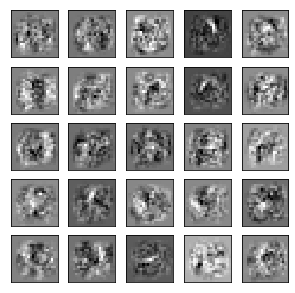

In [47]:
plot_hidden(final_theta)
plt.show()